In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing

Text(0.5, 1.0, 'Test labels')

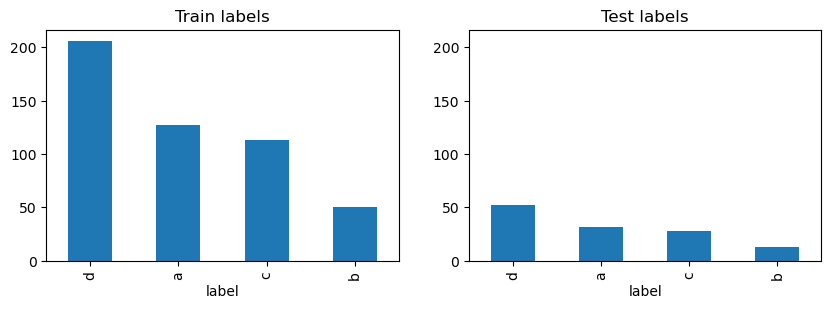

In [70]:
df_crowd = pd.read_csv("umd_reddit_suicidewatch_dataset_v2/crowd/train/crowd_train.csv")
df_crowd_test = pd.read_csv("umd_reddit_suicidewatch_dataset_v2/crowd/test/crowd_test_A.csv")
# create 1x2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
# plot the bar chart
df_crowd.value_counts("label").plot(kind="bar", ax=ax1)
df_crowd_test.value_counts("label").plot(kind="bar", ax=ax2)
# scale same y axis
ax2.set_ylim(ax1.get_ylim())
# set title
ax1.set_title("Train labels")
ax2.set_title("Test labels")

In [2]:
def corpus_loader(df_post_path, df_crowd_path, task="A", include_title=False):
    """
    Load the corpus from the csv files.
    :param df_post_path: path to the csv file containing raw posts
    :param df_crowd_path: path to the csv file containing crowd labels
    :param task: task to load, either "A", "B" or "C"
        - **Task A**: Risk Assessment for SuicideWatch posters based *only* on their
        SuicideWatch postings.
        - **Task B**: Risk Assessment for SuicideWatch posters based on their
        SuicideWatch postings *and* other Reddit postings.
        - **Task C**: Screening. This task looks at posts that are *NOT* on
        SuicideWatch, and determine the user's level of risk. 
    :param include_title: whether to include the post title in the corpus
    :return: a dataframe with two columns: text and label
        'd': '(d) Severe Risk', 
        'c': '(c) Moderate Risk', 
        'b': '(b) Low Risk', 
        'a': '(a) No Risk'
    """
    df_post = pd.read_csv(df_post_path)
    df_crowd = pd.read_csv(df_crowd_path)
    df_suicidewatch = pd.merge(df_post[df_post["subreddit"]=="SuicideWatch"], df_crowd, on="user_id")
    # create a dataframe with all post body and label
    df_suicidewatch_body = df_suicidewatch[["post_body", "label"]].copy()
    # rename the column name
    df_suicidewatch_body = df_suicidewatch_body.rename(columns={"post_body": "text"})

    if include_title:
        # create a dataframe with all post title and label
        df_suicidewatch_title = df_suicidewatch[["post_title", "label"]]
        df_suicidewatch_title.rename(columns={"post_title": "text"}, inplace=True)

        # concat the two dataframe
        df_suicidewatch_corpus = pd.concat([df_suicidewatch_title, df_suicidewatch_body], ignore_index=True)
    else:
        df_suicidewatch_corpus = df_suicidewatch_body
    # remove rows with text length less than 2
    df_suicidewatch_corpus = df_suicidewatch_corpus[df_suicidewatch_corpus["text"].str.split().str.len() > 1]

    return df_suicidewatch_corpus

## Sliding text windows

In [4]:
# slice text into batch of sliding windows of 512 tokens stride 256, form into list of strings, apply to row text
def sliding_window(text, window_size=512, stride=256):
    text = text.split()
    text = [text[i:i+window_size] for i in range(0, len(text), stride)]
    # remove last window if it is less than window_size
    if len(text) > 1:
        if len(text[-2]) < window_size:
            text = text[:-1]
    text = [" ".join(t) for t in text]
    return text

### Example

In [26]:

t = """Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Habitant morbi tristique senectus et netus et malesuada fames ac. Duis convallis convallis tellus id interdum velit laoreet. Iaculis eu non diam phasellus vestibulum lorem sed risus ultricies. Condimentum id venenatis a condimentum vitae sapien. Amet est placerat in egestas erat. Viverra adipiscing at in tellus integer feugiat scelerisque varius. Enim ut tellus elementum sagittis vitae et leo. Enim sit amet venenatis urna cursus eget nunc scelerisque. Pulvinar neque laoreet suspendisse interdum consectetur libero id faucibus. Morbi quis commodo odio aenean sed adipiscing diam donec."""
print(t)
print()
for s in sliding_window(t,50,25):
    print(f"({len(s.split())}) {s}")
    print()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Habitant morbi tristique senectus et netus et malesuada fames ac. Duis convallis convallis tellus id interdum velit laoreet. Iaculis eu non diam phasellus vestibulum lorem sed risus ultricies. Condimentum id venenatis a condimentum vitae sapien. Amet est placerat in egestas erat. Viverra adipiscing at in tellus integer feugiat scelerisque varius. Enim ut tellus elementum sagittis vitae et leo. Enim sit amet venenatis urna cursus eget nunc scelerisque. Pulvinar neque laoreet suspendisse interdum consectetur libero id faucibus. Morbi quis commodo odio aenean sed adipiscing diam donec.

(50) Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Habitant morbi tristique senectus et netus et malesuada fames ac. Duis convallis convallis tellus id interdum velit laoreet. Iaculis eu non diam phasellus v

### Continue preprocessing

In [5]:
def sliding_window_corpus(df_corpus, window_size=512, stride=256):
    """
    Slice the text in the corpus into sliding windows with stride.
    :param df_corpus: a dataframe with two columns: text and label
    :param window_size: the size of the sliding window
    :param stride: the stride of the sliding window
    :return: a dataframe with two columns: text and label
    """
    # apply sliding window to each text
    df_corpus["text"] = df_corpus["text"].apply(sliding_window, args=(window_size, stride))
    # explode the sliding windows into rows
    df_corpus = df_corpus.explode("text")
    return df_corpus

def preprocess(df_post_path, df_crowd_path, task="A", include_title=False, window_size=512, stride=256):
    """
    Preprocess the corpus from the csv files.
    :params df_post_path, df_crowd_path: path to the csv files
    :params task, include_title: see corpus_loader()
    :params window_size, stride: see sliding_window_corpus()
    :return: a dataframe with two columns: text and label
        Label is re-encoded as:
        0: '(a) No Risk'
        1: '(b) Low Risk'
        2: '(c) Moderate Risk'
        3: '(d) High Risk'
    """
    # load corpus
    df_corpus = corpus_loader(df_post_path, df_crowd_path, task=task, include_title=include_title)

    # apply sliding window to each text
    df_corpus = sliding_window_corpus(df_corpus, window_size=window_size, stride=stride)

    # reset index
    df_corpus.reset_index(drop=True, inplace=True)
    # encode label a b c d to 0 1 2 3
    df_corpus["label"] = df_corpus["label"].map({"a": 0, "b": 1, "c": 2, "d": 3})

    return df_corpus

In [6]:
df_sw_corpus_train = preprocess("umd_reddit_suicidewatch_dataset_v2/crowd/train/shared_task_posts.csv","umd_reddit_suicidewatch_dataset_v2/crowd/train/crowd_train.csv")
df_sw_corpus_test = preprocess("umd_reddit_suicidewatch_dataset_v2/crowd/test/shared_task_posts_test.csv","umd_reddit_suicidewatch_dataset_v2/crowd/test/crowd_test_A.csv")

# Fine-tuning transformer model(s)

In [2]:
import pandas as pd

In [3]:
df_sw_corpus_train = pd.read_parquet("umd/train.parquet.gzip")

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

/home1/vnguyen2014/mambaforge/envs/dl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-27 14:56:14.080963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 14:56:14.246190: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Tokenization

In [9]:
def tokenize_df(df_corpus, model_name, seed=42):
    """
    Tokenize the corpus using the model_name.
    :param df_corpus: a pandas dataframe with two columns: text and label
    :param model_name: the name of the model
    :return: a dictionary with keys "input_ids", "attention_mask", "label"
    """
    # load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # load df into Dataset
    dataset = Dataset.from_pandas(df_corpus)
    # tokenize the corpus
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length"), batched=True)

    # format object to be used by the model
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])
    tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
    tokenized_dataset.set_format("torch")
    tokenized_dataset = tokenized_dataset.shuffle(seed=seed)
    return tokenized_dataset

In [12]:
model_list = ["mental/mental-roberta-base", "mental/mental-bert-base-uncased", "AIMH/mental-roberta-large", "AIMH/mental-bert-base-cased", "AIMH/mental-bert-large-uncased"]
tokenized_dataset_train = tokenize_df(df_sw_corpus_train, "mental/mental-bert-base-uncased")
tokenized_dataset_test = tokenize_df(df_sw_corpus_test, "mental/mental-bert-base-uncased")

In [15]:
# fine-tune the model
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate

In [1]:
def train_trainer_ddp():
    model = model
    metric = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)
    
    # fine-tune the model
    training_args = TrainingArguments(
        output_dir="./results",          # output directory
        num_train_epochs=5,              # total # of training epochs
        per_device_train_batch_size=64,  # batch size per device during training
        per_device_eval_batch_size=64,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=10,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        torch_compile=True,
    )

    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=tokenized_dataset_train,         # training dataset
        eval_dataset=tokenized_dataset_test,            # evaluation dataset
        compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    )

    trainer.train()

In [ ]:
from accelerate import notebook_launcher
notebook_launcher(train_trainer_ddp, num_processes=4)

In [1]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6007